View the full project at - 
https://www.kaggle.com/code/natecekay/nlp-sentiment-classification

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import torch
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments, pipeline


C:\Users\cekay\tensorflow_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
random.seed(42)

In [3]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
data1 = pd.read_csv('C:/Users/cekay/OneDrive/Desktop/NLP Model/Education.csv')
data2 = pd.read_csv('C:/Users/cekay/OneDrive/Desktop/NLP Model/Finance.csv')
data3 = pd.read_csv('C:/Users/cekay/OneDrive/Desktop/NLP Model/Politics.csv')
data4 = pd.read_csv('C:/Users/cekay/OneDrive/Desktop/NLP Model/Sports.csv')

In [5]:
# standardize column names and combine datasets
data1.columns = data1.columns.str.strip().str.lower()
data2.columns = data2.columns.str.strip().str.lower()
data3.columns = data3.columns.str.strip().str.lower()
data4.columns = data4.columns.str.strip().str.lower()

In [6]:
combined_data = pd.concat([data1, data2, data3, data4], ignore_index=True).drop_duplicates().dropna()


In [7]:
combined_data

,text,label
0,The impact of educational reforms remains unce...,positive
1,Critics argue that recent improvements in the ...,negative
2,Innovative teaching methods have led to unexpe...,positive
3,"Despite budget constraints, the school has man...",positive
4,The true effectiveness of online learning plat...,negative
...,...,...
204,Sports fandom can foster a sense of community ...,positive
205,Sports events offer a platform for showcasing ...,positive
206,The pressure to win in sports can overshadow t...,negative
207,Sports programs in schools play a crucial role...,positive


In [8]:
# creating 17 synthetic negative responses to even distribution of positive and negative responses
negative_responses = [
    "The budget cuts have negatively impacted the quality of education.",
    "The lack of transparency in the process has caused widespread dissatisfaction.",
    "Students have reported feeling unmotivated due to outdated teaching methods.",
    "The current system fails to address the needs of struggling students.",
    "The high cost of tuition has created a barrier for many potential learners.",
    "Administrative delays have led to missed opportunities for students.",
    "The online learning platform lacks engagement and interactivity.",
    "The policies are criticized for being overly bureaucratic and rigid.",
    "Frequent technical issues disrupt the flow of online classes.",
    "Limited access to resources has made learning challenging for many students.",
    "The current curriculum is seen as irrelevant to real-world applications.",
    "The inconsistent grading system has led to frustration among students.",
    "Excessive focus on standardized testing undermines creativity in classrooms.",
    "Many students feel unsupported due to a lack of mental health resources.",
    "Teachers express frustration over a lack of professional development opportunities.",
    "Parents have complained about the poor communication from school administrations.",
    "The focus on profits has overshadowed the quality of education provided."
]

# adding these responses into a dataset
new_data = pd.DataFrame({
    'text': negative_responses,
    'label': ['negative'] * len(negative_responses)
})



In [9]:
# combining the responses with the original dataset
combined_data = pd.concat([combined_data, new_data], ignore_index=True)

In [10]:
#adding responses to increase model accuracy 
positive_responses = [
    "Your dedication to learning is inspiring!",
    "Fantastic progress in your studies!",
    "You're mastering these concepts beautifully!",
    "Your passion for education shines through!",
    "You're making amazing strides in your learning!",
    "Keep excelling in your academic journey!",
    "You're a true scholar!",
    "Your curiosity is your greatest asset!",
    "Outstanding effort in your studies!",
    "You're achieving great heights in education!",
    "Your leadership is truly commendable!",
    "Fantastic strategy and execution!",
    "You're making a positive impact in the political arena!",
    "Your dedication to public service is admirable!",
    "You're inspiring positive change!",
    "Your commitment to the community is exemplary!",
    "You're an advocate for progress!",
    "Your vision for the future is inspiring!",
    "You're leading with integrity and purpose!",
    "Your efforts are shaping a better society!",
    "Outstanding performance on the field!",
    "Your determination in sports is incredible!",
    "Fantastic teamwork and spirit!",
    "You're a true champion!",
    "Your hard work in training is paying off!",
    "Keep breaking records!",
    "You're an inspiration to athletes everywhere!",
    "Your sportsmanship is commendable!",
    "You're achieving greatness in every game!",
    "Your passion for sports is unmatched!",
    "Your financial planning is top-notch!",
    "Fantastic investment strategies!",
    "You're building a solid financial future!",
    "Your understanding of the market is impressive!",
    "You're a financial wizard!",
    "Your budgeting skills are exceptional!",
    "You're achieving remarkable financial goals!",
    "Your insight into finance is invaluable!",
    "You're a savvy investor!",
    "You're mastering the art of finance!",
    "Your progress in this course is exceptional!",
    "You're setting a high standard for academic excellence!",
    "Your love for learning is contagious!",
    "You're turning every challenge into an opportunity to grow!",
    "Your persistence in education is commendable!",
    "Keep reaching for new academic heights!",
    "Your commitment to knowledge is remarkable!",
    "You're making a significant impact in education!",
    "You're transforming the way we think about learning!",
    "Your dedication to academic success is unparalleled!",
    "You're championing important causes with grace!",
    "Your approach to policy is innovative and effective!",
    "You're driving meaningful conversations in politics!",
    "Your advocacy for the people is outstanding!",
    "You're setting an example of ethical leadership!",
    "Your efforts in political reform are remarkable!",
    "You're a beacon of hope in the political landscape!",
    "Your strategies are paving the way for a brighter future!",
    "You're making history with your actions!",
    "Your vision for change is inspiring generations!",
    "Your agility and skill are incredible!",
    "You're a standout player in every match!",
    "Your commitment to excellence in sports is inspiring!",
    "You're redefining what it means to be an athlete!",
    "Your victories are a testament to your hard work!",
    "You're pushing the boundaries of athletic achievement!",
    "Your resilience in sports is admirable!",
    "You're a role model for aspiring athletes!",
    "Your success on the field is well-deserved!",
    "You're leaving an indelible mark in the sports world!",
    "Your financial acumen is remarkable!",
    "You're navigating complex financial landscapes with ease!",
    "Your approach to wealth management is outstanding!",
    "You're a pioneer in financial innovation!",
    "Your foresight in investments is unmatched!",
    "You're a trailblazer in the finance industry!",
    "Your financial achievements are awe-inspiring!",
    "You're building a legacy of financial success!",
    "Your expertise in finance is a game-changer!",
    "You're creating financial opportunities for many!",
    "Your determination in every area is remarkable!",
    "You're making a difference in the world!",
    "Your achievements are an inspiration to all!",
    "You're excelling in every challenge you take on!",
    "Your persistence and passion are unmatched!",
    "You're setting a new standard for success!",
    "Your creativity and innovation are making waves!",
    "You're achieving extraordinary results!",
    "You're a true inspiration in every endeavor!",
    "Keep reaching for the stars!"
]

negative_responses = [
    "You need to focus more on your studies.",
    "This approach isn’t working well for your education.",
    "There’s room for improvement in your learning strategy.",
    "You’re not giving your best effort in academics.",
    "Your progress is slower than expected.",
    "You could be more consistent in your studies.",
    "You’re falling behind on your educational goals.",
    "Your commitment to learning seems to be lacking.",
    "You need to pay more attention in class.",
    "Your academic performance is disappointing.",
    "Your policies aren’t addressing key issues effectively.",
    "This strategy lacks clarity and focus.",
    "Your leadership in politics is underwhelming.",
    "You’re not communicating your vision well enough.",
    "There’s a lack of progress in your political goals.",
    "You need to collaborate more with stakeholders.",
    "Your decisions are alienating your supporters.",
    "You’re not addressing the community’s concerns.",
    "Your political campaign lacks energy.",
    "Your strategies aren’t resonating with the public.",
    "Your performance on the field needs improvement.",
    "You’re not showing enough determination in sports.",
    "Your teamwork skills are below expectations.",
    "You’re not training as hard as you could.",
    "Your game lacks strategy and execution.",
    "You’re not fully utilizing your potential in sports.",
    "Your attitude on the field needs adjustment.",
    "Your recent matches have been lackluster.",
    "Your fitness level is affecting your performance.",
    "You’re not demonstrating leadership in the game.",
    "Your financial planning needs significant improvement.",
    "This investment strategy is not effective.",
    "Your budgeting skills are falling short.",
    "You’re not managing your finances well.",
    "Your savings plan needs more attention.",
    "You’re not analyzing the market effectively.",
    "Your financial decisions lack foresight.",
    "You’re not tracking your expenses accurately.",
    "Your goals in finance are unrealistic.",
    "You’re not achieving financial stability.",
    "Your study methods are inconsistent.",
    "You’re not engaging enough with your coursework.",
    "Your academic goals are unclear.",
    "You need to be more proactive in your studies.",
    "Your effort in school is not satisfactory.",
    "You’re not taking your education seriously enough.",
    "Your learning pace is too slow.",
    "You’re not prioritizing your academics.",
    "You’re not seeking help when needed in your studies.",
    "Your engagement with your education is minimal.",
    "Your policy lacks innovative solutions.",
    "You’re not addressing important challenges in politics.",
    "Your public speaking skills need improvement.",
    "Your campaign lacks a clear message.",
    "You’re not building enough trust with your constituents.",
    "Your political actions are inconsistent.",
    "You’re not creating meaningful partnerships in politics.",
    "Your decisions are not well-informed.",
    "You’re not inspiring confidence in your leadership.",
    "You’re not delivering on your political promises.",
    "You’re not giving your best performance in sports.",
    "Your focus during games is lacking.",
    "You’re not improving your skills in training.",
    "You’re not working well with your teammates.",
    "Your preparation for matches is inadequate.",
    "You’re not maintaining discipline on the field.",
    "You’re not adapting to challenges in sports.",
    "Your performance consistency is poor.",
    "You’re not utilizing your strengths effectively.",
    "You’re not setting a good example in sportsmanship.",
    "Your financial goals are not well-defined.",
    "You’re not saving enough for future needs.",
    "Your expenses are exceeding your income.",
    "You’re not diversifying your investments.",
    "Your financial risks are too high.",
    "You’re not planning for unexpected costs.",
    "Your spending habits need better control.",
    "You’re not building a strong credit score.",
    "You’re not setting achievable financial milestones.",
    "You’re not managing your financial priorities effectively.",
    "Your classroom participation needs improvement.",
    "You’re not setting realistic academic goals.",
    "You’re not effectively managing your time for studies.",
    "You’re not staying updated on current political trends.",
    "You’re neglecting critical issues in your policies.",
    "Your sports preparation needs more effort.",
    "Your financial record-keeping is inadequate.",
    "Your approach to teamwork in sports needs improvement.",
    "Your lack of discipline is holding you back in academics.",
    "You’re not effectively using resources to achieve your goals."
]

positive_df = pd.DataFrame({"text": positive_responses, "label": "positive"})
negative_df = pd.DataFrame({"text": negative_responses, "label": "negative"})

In [11]:
positive_df

,text,label
0,Your dedication to learning is inspiring!,positive
1,Fantastic progress in your studies!,positive
2,You're mastering these concepts beautifully!,positive
3,Your passion for education shines through!,positive
4,You're making amazing strides in your learning!,positive
...,...,...
85,You're setting a new standard for success!,positive
86,Your creativity and innovation are making waves!,positive
87,You're achieving extraordinary results!,positive
88,You're a true inspiration in every endeavor!,positive


In [12]:
negative_df

,text,label
0,You need to focus more on your studies.,negative
1,This approach isn’t working well for your educ...,negative
2,There’s room for improvement in your learning ...,negative
3,You’re not giving your best effort in academics.,negative
4,Your progress is slower than expected.,negative
...,...,...
85,Your sports preparation needs more effort.,negative
86,Your financial record-keeping is inadequate.,negative
87,Your approach to teamwork in sports needs impr...,negative
88,Your lack of discipline is holding you back in...,negative


In [13]:
# adding the responses to the existing DataFrame
combined_data = pd.concat([combined_data, positive_df, negative_df], ignore_index=True)

In [14]:
combined_data['label'].value_counts()

label
positive    203
negative    203
Name: count, dtype: int64

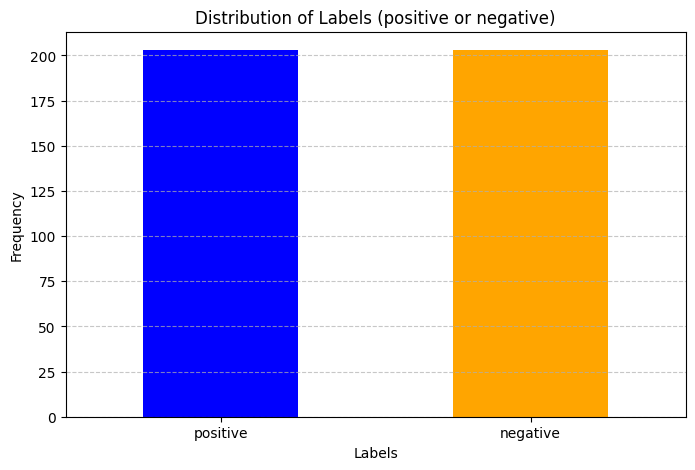

In [15]:
label_distribution = combined_data['label'].value_counts()

# Plotting the distribution
plt.figure(figsize=(8, 5))
label_distribution.plot(kind='bar', color=['blue', 'orange'])
plt.title("Distribution of Labels (positive or negative)")
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [16]:
# Prepare data
X = combined_data['text'].tolist()
y = LabelEncoder().fit_transform(combined_data['label'])


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# tokenizing the data
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=512, return_tensors="pt")


In [20]:
# converting labels to tensors
train_labels = torch.tensor(y_train)
test_labels = torch.tensor(y_test)


In [21]:
# create a custom dataset class
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item


In [22]:
train_dataset = SentimentDataset(train_encodings, train_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

In [23]:
grid = {
    'learning_rate': [1e-5, 2e-5, 5e-5],
    'batch_size': [16, 32],
    'num_train_epochs': [3, 5],
    'weight_decay': [0.0, 0.01]
}

# generate all combinations of parameters
param_combinations = list(ParameterGrid(grid))

best_accuracy = 0
best_params = {}

for params in param_combinations:
    print(f"Testing params: {params}")

    # defining training arguments
    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        learning_rate=params['learning_rate'],
        per_device_train_batch_size=params['batch_size'],
        num_train_epochs=params['num_train_epochs'],
        weight_decay=params['weight_decay'],
        logging_dir="./logs",
        logging_steps=10,
        save_strategy="no"
    )

    # initilize the trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer
    )


Testing params: {'batch_size': 16, 'learning_rate': 1e-05, 'num_train_epochs': 3, 'weight_decay': 0.0}


C:\Users\cekay\tensorflow_env\lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\cekay\AppData\Local\Temp\ipykernel_7344\2745548030.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Testing params: {'batch_size': 16, 'learning_rate': 1e-05, 'num_train_epochs': 3, 'weight_decay': 0.01}
Testing params: {'batch_size': 16, 'learning_rate': 1e-05, 'num_train_epochs': 5, 'weight_decay': 0.0}
Testing params: {'batch_size': 16, 'learning_rate': 1e-05, 'num_train_epochs': 5, 'weight_decay': 0.01}
Testing params: {'batch_size': 16, 'learning_rate': 2e-05, 'num_train_epochs': 3, 'weight_decay': 0.0}
Testing params: {'batch_size': 16, 'learning_rate': 2e-05, 'num_train_epochs': 3, 'weight_decay': 0.01}
Testing params: {'batch_size': 16, 'learning_rate': 2e-05, 'num_train_epochs': 5, 'weight_decay': 0.0}
Testing params: {'batch_size': 16, 'learning_rate': 2e-05, 'num_train_epochs': 5, 'weight_decay': 0.01}
Testing params: {'batch_size': 16, 'learning_rate': 5e-05, 'num_train_epochs': 3, 'weight_decay': 0.0}
Testing params: {'batch_size': 16, 'learning_rate': 5e-05, 'num_train_epochs': 3, 'weight_decay': 0.01}
Testing params: {'batch_size': 16, 'learning_rate': 5e-05, 'num_trai

In [24]:
# training BERT
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.526200,0.354760
2,0.255300,0.306365
3,0.101100,0.271635
4,0.095900,0.294197
5,0.036100,0.280808


TrainOutput(global_step=55, training_loss=0.1860762509432706, metrics={'train_runtime': 180.8843, 'train_samples_per_second': 8.956, 'train_steps_per_second': 0.304, 'total_flos': 20812495590000.0, 'train_loss': 0.1860762509432706, 'epoch': 5.0})

In [25]:
results = trainer.evaluate()
print("Evaluation Results:", results)

Evaluation Results: {'eval_loss': 0.2808079123497009, 'eval_runtime': 2.1241, 'eval_samples_per_second': 38.604, 'eval_steps_per_second': 5.179, 'epoch': 5.0}


In [26]:
# classification metrics
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(axis=-1)
from sklearn.metrics import classification_report, accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9146341463414634
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92        43
           1       0.92      0.90      0.91        39

    accuracy                           0.91        82
   macro avg       0.92      0.91      0.91        82
weighted avg       0.91      0.91      0.91        82



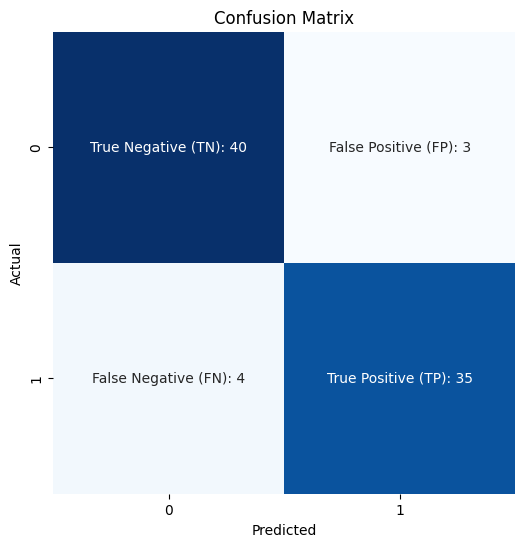

In [27]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

labels = np.array([
    [f"True Negative (TN): {cm[0, 0]}", f"False Positive (FP): {cm[0, 1]}"],
    [f"False Negative (FN): {cm[1, 0]}", f"True Positive (TP): {cm[1, 1]}"]
])

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, square=True, ax=ax)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()


In [28]:
sentiment_analyzer = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


In [29]:
sample_texts = [
    "That was an amazing movie, one of the best I have ever seen!",
    "That was a terrible election, it made me so angry.", 
    "That test was easy, I am sure that I got a perfect score.",
    "That restaurant was not very good, the food was bland and uninspired."
]


In [30]:
for text in sample_texts:
    result = sentiment_analyzer(text)
    sentiment = result[0]['label']  # Get the predicted sentiment (e.g., 'POSITIVE' or 'NEGATIVE')
    print(f"Text: {text}\nPredicted Sentiment: {sentiment}\n")


Text: That was an amazing movie, one of the best I have ever seen!
Predicted Sentiment: POSITIVE

Text: That was a terrible election, it made me so angry.
Predicted Sentiment: NEGATIVE

Text: That test was easy, I am sure that I got a perfect score.
Predicted Sentiment: POSITIVE

Text: That restaurant was not very good, the food was bland and uninspired.
Predicted Sentiment: NEGATIVE



In [ ]:
# load the sentiment analysis pipeline
sentiment_analyzer = pipeline("sentiment-analysis")

# create a function for testing custom responses
def test_custom_responses():
    print("Type your text to test sentiment (type 'exit' to quit):")
    while True:
        user_input = input("Enter text: ").strip()
        
        if user_input.lower() == 'exit':
            print("Exiting sentiment tester. Goodbye!")
            break
        
        result = sentiment_analyzer(user_input)
        sentiment = result[0]['label']  
        score = result[0]['score']  
        
        print(f"Text: {user_input}\nPredicted Sentiment: {sentiment} (Confidence: {score:.2f})\n")

test_custom_responses()

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


Type your text to test sentiment (type 'exit' to quit):


Enter text:  That election was the worst I have ever seen


Text: That election was the worst I have ever seen
Predicted Sentiment: NEGATIVE (Confidence: 1.00)



Enter text:  That class was fun and easy, I thoroughly enjoyed it!


Text: That class was fun and easy, I thoroughly enjoyed it!
Predicted Sentiment: POSITIVE (Confidence: 1.00)

